In [59]:
from importlib import reload
from earthtext.io import io
from earthtext.datamodules import chipmultilabel
from earthtext.datamodules.components.chipmultilabel import esawc_map
from progressbar import progressbar as pbar
from rlxutils import subplots
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from sklearn.ensemble import RandomForestRegressor
from pyproj import CRS
epsg4326 = CRS.from_epsg(4326)

reload(chipmultilabel)
reload(io)

<module 'earthtext.io.io' from '/home/ubuntu/earth-text/src/earthtext/io/io.py'>

In [2]:
mfile = '/opt/data/california-worldcover-chips/california-worldcover-chips-osm-multilabels.parquet'
embeddings_folder = "/opt/data/california-worldcover-chips/embeddings_v0.2"

In [3]:
cm = chipmultilabel.ChipMultilabelModule(
                            metadata_file = mfile,
                            chips_folder = None, 
                            embeddings_folder = embeddings_folder, 
                            patch_embeddings_folder = None,
                            get_strlabels = True,
                            get_esawc_proportions = True,
                            get_chip_id = True,
                            batch_size = 4,
                            min_ohe_count = 1
     )

2024-04-06 00:11:52.634 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:64 - checking chip files for train split
100% (60396 of 60396) |##################| Elapsed Time: 0:00:03 Time:  0:00:030000
2024-04-06 00:11:56.147 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:68 - read train split with 60295 chip files (out of 60396)
2024-04-06 00:11:56.862 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:64 - checking chip files for val split
100% (12304 of 12304) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-04-06 00:11:57.556 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:68 - read val split with 12288 chip files (out of 12304)
2024-04-06 00:11:58.339 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:64 - checking chip files for test split
100% (13419 of 13419) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-04-06 00:11:59.112 | INFO     | earth

In [4]:
tr = cm.train_dataloader()

In [5]:
batch = next(iter(tr))

In [6]:
{k: len(v) for k,v in batch.items()}

{'multilabel': 4,
 'chip_id': 4,
 'embedding': 4,
 'str_multilabel': 4,
 'esawc_proportions': 4}

In [7]:
batch['chip_id']

['0f63b52c1ea26', '000c0a577057b', '0b0914e250f38', '0fcf70b34d4f9']

In [8]:
def get_embeddings_and_esawc_proportions(dataloader):
    embeddings = []
    esawc_proportions = []
    chip_ids = []
    for batch in pbar(iter(dataloader)):
        for i in batch['embedding']:
            embeddings.append(i.numpy())
        for i in batch['esawc_proportions']:
            esawc_proportions.append(eval(i))
        for i in batch['chip_id']:
            chip_ids.append(i)
    embeddings = np.r_[embeddings]
    esawc_proportions = [{} if i is None else i for i in esawc_proportions]
    esawc_proportions = pd.DataFrame(esawc_proportions).fillna(0)
    return chip_ids, embeddings, esawc_proportions

In [9]:
test_dl  = cm.test_dataloader()
train_dl = cm.train_dataloader()
val_dl   = cm.val_dataloader()

In [10]:
tr_chip_ids, tr_embeddings, tr_esawc_proportions = get_embeddings_and_esawc_proportions(train_dl)

100% (15074 of 15074) |##################| Elapsed Time: 0:00:19 Time:  0:00:190001


In [11]:
ts_chip_ids, ts_embeddings, ts_esawc_proportions = get_embeddings_and_esawc_proportions(test_dl)

100% (3353 of 3353) |####################| Elapsed Time: 0:00:04 Time:  0:00:040000


In [12]:
val_chip_ids, val_embeddings, val_esawc_proportions = get_embeddings_and_esawc_proportions(val_dl)

100% (3072 of 3072) |####################| Elapsed Time: 0:00:04 Time:  0:00:040000


In [147]:
def fitrf(esawc_target_class, estimator):
    print (f"fitting to {esawc_target_class}")
    Xtr = tr_embeddings
    ytr = tr_esawc_proportions[esawc_target_class].values
    
    Xts = ts_embeddings
    yts = ts_esawc_proportions[esawc_target_class].values
    
    Xval = val_embeddings
    yval = val_esawc_proportions[esawc_target_class].values
    
    estimator.fit(Xtr,ytr)
    
    predtr  = estimator.predict(Xtr)
    predts  = estimator.predict(Xts)
    predval = estimator.predict(Xval)
    
    r = {'results':
         {
             'train': np.mean(np.abs(predtr - ytr)), 
             'test': np.mean(np.abs(predts - yts)), 
             'val': np.mean(np.abs(predval - yval))
         },
         'targets': {
             'ytr': ytr, 'predtr': predtr, 
             'yval': yval, 'predval': predval,
             'yts': yts, 'predts': predts
         }
        }
    return r

def plot_rf_results(results):
    rdf = pd.DataFrame({k:v['results'] for k,v in results.items()}).T
    rdf_esawc_classes = rdf.index.copy()
    rdf.index = [f"{esawc_map[k]} {k}" for k in rdf.index]
    rdf.plot(kind='bar', figsize=(10,3))
    plt.title(str(estimator)+ "\ncircles represent the distribution of classes")
    plt.grid()
    
    tr_esawc_classdistrib = tr_esawc_proportions.sum(axis=0) / tr_esawc_proportions.values.sum() 
    rdf_max = rdf.values.max()
    for i,c in enumerate(rdf_esawc_classes):
        pct = dict(tr_esawc_classdistrib)[c]
        plt.scatter(i, rdf_max*1.2, s=int(10000*pct), color='gray', alpha=.5)
        plt.text(i-.25, rdf_max*1.2, f"{pct*100:.2f}%")
        #print (i, tr_esawc_classdistrib[i])
    plt.ylim(0, rdf_max*1.5)

In [14]:
estimator = RandomForestRegressor(n_jobs=30, max_depth=20, n_estimators=20)
r_overfit = {esawc_class:fitrf(esawc_class, estimator) for esawc_class in esawc_map.keys()}

fitting to 10
fitting to 20
fitting to 30
fitting to 40
fitting to 50
fitting to 60
fitting to 70
fitting to 80
fitting to 90
fitting to 95
fitting to 100


In [15]:
r_overfit['10']['results']

{'train': 0.038873729224687535,
 'test': 0.10086791451760564,
 'val': 0.09786756621593352}

In [16]:
estimator = RandomForestRegressor(n_jobs=30, max_depth=10, n_estimators=10)
r_justright = {esawc_class:fitrf(esawc_class, estimator) for esawc_class in esawc_map.keys()}

fitting to 10
fitting to 20
fitting to 30
fitting to 40
fitting to 50
fitting to 60
fitting to 70
fitting to 80
fitting to 90
fitting to 95
fitting to 100


Text(0, 0.5, 'mean absolute prediction error')

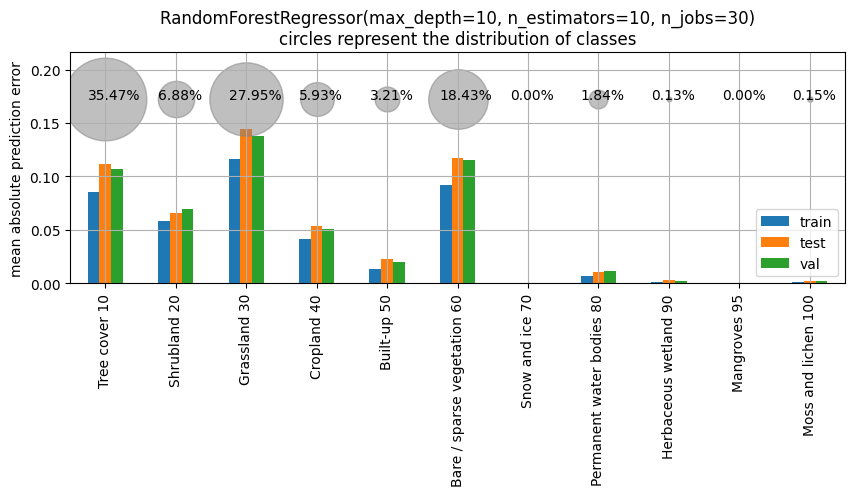

In [149]:
plot_rf_results(r_justright)
plt.ylabel("mean absolute prediction error")

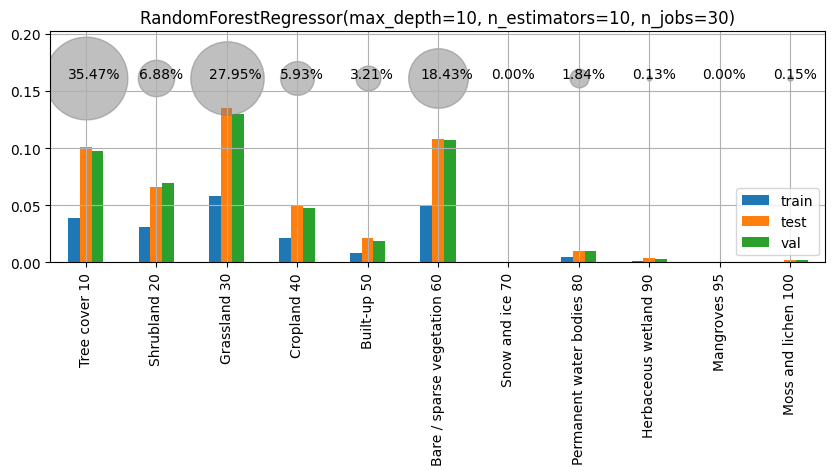

In [40]:
plot_rf_results(r_overfit)

Text(0.5, 1.0, 'train - test - val split')

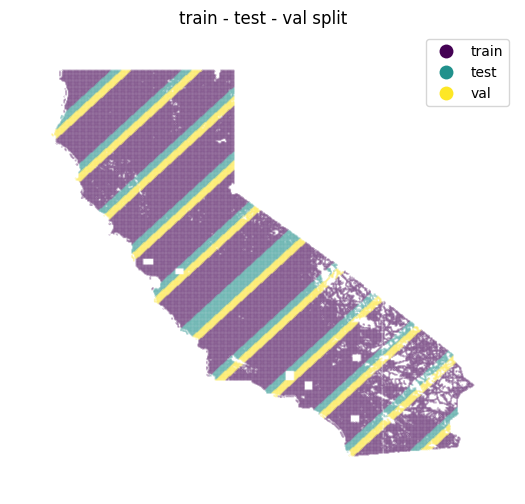

In [146]:
z = gpd.GeoDataFrame(pd.DataFrame([tr_chip_ids + ts_chip_ids + val_chip_ids, 
                                   [0]*len(tr_chip_ids) + [1]*len(ts_chip_ids) + [2]*len(val_chip_ids),
                                   list(train_dl.dataset.metadata.loc[tr_chip_ids].geometry) + \
                                   list(test_dl.dataset.metadata.loc[ts_chip_ids].geometry) + \
                                   list(val_dl.dataset.metadata.loc[val_chip_ids].geometry)
                                      ], 
                         index=['chip_id', 'split', 'geometry']).T, crs=epsg4326)
z['geometry'] = [i.centroid for i in z.geometry]
gplt.pointplot(z, hue='split', s=0.1, legend=True, legend_labels=['train', 'test', 'val']);
plt.title(f"train - test - val split")



In [169]:
esawc_class = '50'

def plot_map(results, esawc_class):
    import geoplot as gplt
    
    ytr  = results[esawc_class]['targets']['ytr']
    yts  = results[esawc_class]['targets']['yts']
    yval = results[esawc_class]['targets']['yval']
    predstr  = results[esawc_class]['targets']['predtr'].copy()
    predstr[predstr<0.04] = 0
    predsts  = results[esawc_class]['targets']['predts'].copy()
    predsts[predsts<0.04] = 0
    predsval = results[esawc_class]['targets']['predval'].copy()
    predsval[predsval<0.04] = 0
    
    z = gpd.GeoDataFrame(pd.DataFrame([tr_chip_ids + ts_chip_ids + val_chip_ids, 
                                       list(ytr) + list(yts) + list(yval), 
                                       list(predstr) + list(predsts) + list(predsval), 
                                       list(train_dl.dataset.metadata.loc[tr_chip_ids].geometry) + \
                                       list(test_dl.dataset.metadata.loc[ts_chip_ids].geometry) + \
                                       list(val_dl.dataset.metadata.loc[val_chip_ids].geometry)
                                      
                                      ], 
                         index=['chip_id', 'label', 'prediction', 'geometry']).T, crs=epsg4326)
    z['geometry'] = [i.centroid for i in z.geometry]
    
    for ax,i in subplots(2):
        if i==0:
            gplt.pointplot(z, hue='label', s=0.1, ax=ax);
            plt.title(f"labels for esawc class {esawc_class}\n{esawc_map[esawc_class]}")
        if i==1:
            gplt.pointplot(z, hue='prediction', s=0.1, ax=ax);
            plt.title(f"predictions for esawc class {esawc_class}\n{esawc_map[esawc_class]}")
    


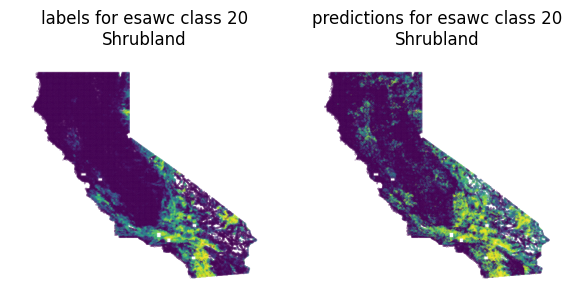

In [170]:
plot_map(r_justright, esawc_class='20')

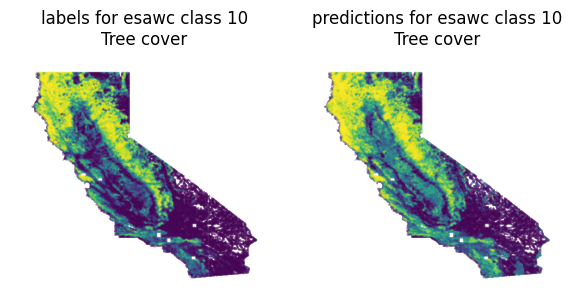

In [159]:
plot_map(r_justright, esawc_class='10')